<img src="images/dwave_leap.png" width="500 px" align="center">

# Solving Optimization Problems on DWAVE





Optimization in general is to find the best choice among a set of options, subject to a set of constraints. Formulated in words

<div align=center>
optimize <strong>objective</strong><br>
by varying <strong>variables</strong><br>
subject to <strong>constraints</strong>
</div>
<br>

We can use D-Wave to solve these kind of problems if the objective and constraints are quadratic at most and the variables have binary values.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# How to build a QUBO - Part 2

Let us consider the following optimization problem with constraints:
    
**Problem**: 

You have the following set of numbers $A=\{1,2,3,4,5\}$. Find $3$ numbers in $A$ that add up to $8$.

**Step 1**: Formulate the problem within its domain 

<div align=left>
    <i>objective</i>:&nbsp; minimize sum over numbers in $A$ <br>
    <i>variables</i>:&nbsp;  correspond to one of the values in $A$ each <br>
    <i>constraints</i>: <ul>
    <li>pick just $3$ numbers</li>
    <li>sum over all numbers is equal to $8$</li>
    </ul>
    
</div>

**Step 2**: Convert objective and constraints to statements with binary variables

We introduce binary variables $x$ for each number in $A$. The variable $x_i$ is equal to $1$ if the corresponding 
number $i$ is part of the solution and $0$ otherwise. Than our objective and constraint read

$$
\textrm{obj:}\hspace{.5cm}\min_{x\in\{0,1\}}\sum_{i=1}^5 i x_i
$$

$$
\textrm{const:}\hspace{.45cm}\sum_{i=1}^5 x_i = 3, \hspace{.5cm}\sum_{i=1}^5 i x_i = 8
$$

**Step 3**: Make the objective and constraints "QUBO appropriate"
- objective is a minimization function
- constraints are satisfied at their minimum value

Lets QUBOfy our objective function.

$$
\textrm{obj:}\hspace{.5cm}\min_{x \in \{0,1\}} \sum_{i=1}^5 i x_i
$$

and for our constrains

$$
\textrm{const:}\hspace{.5cm}\sum_{i=1}^5 x_i - 3,\hspace{.5cm}\sum_{i=1}^5 i x_i - 8
$$

But stop! This is **not correct** because the minimum of these constraints would be the trivial solution $\forall x_i=0$. To avoid this trivial solution we have to **square** the above functions. So the correct constraints are

$$
\textrm{const:}\hspace{.5cm}\left(\sum_{i=1}^5 x_i - 3\right)^2,\hspace{.5cm}\left(\sum_{i=1}^5 i x_i - 8\right)^2
$$


**Step 4**: Combine your objective and constraint 

This gives our final QUBO which reads

$$
   \textrm{QUBO:} \hspace{.5cm} \min_{x \in \{0,1\}} \left[  \left( \sum_{i=1}^5 i x_i - 8 \right) + \gamma  \left(\sum_{i=1}^5 x_i - 3\right)^2 + \gamma \left( \sum_{i=1}^5 i x_i - 8 \right)^2\right]
$$

Here we introduced the parameter $\gamma$ which defines the _penalty strength_ that tunes the impact of our constraint on the overall QUBO. 

Lets run the code to see that it works...

In [2]:
import dimod
from pyqubo import Binary 

# objective
obj = sum([x*Binary(str(x)) for x in range(1,6)]) - 8

# constraints
const = (sum([Binary(str(x)) for x in range(1,6)]) - 3)**2 + ( sum([x*Binary(str(x)) for x in range(1,6)]) - 8)**2

# penalty strength
gamma = 10

# create QUBO
qubo = obj + gamma*const

In [3]:
# transform from pyqubo to dimod object
model = qubo.compile()
Q, offset = model.to_qubo()

# create BQM
bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset=offset)

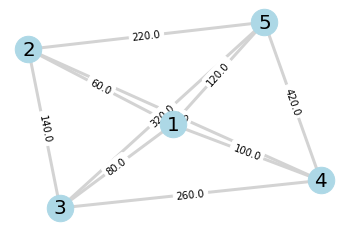

In [4]:
from utils.libqubo import show_bqm_graph
show_bqm_graph(bqm)

In [12]:
exactsolver = dimod.ExactSolver()
sampleset = exactsolver.sample(bqm)

# print the results with lowest energy
sampleset.lowest().to_pandas_dataframe()

,0,1,2,3,energy,num_occurrences
0,1,1,0,0,8.0,1
1,0,1,1,0,8.0,1
2,1,0,1,0,8.0,1
3,0,0,1,1,8.0,1
4,0,1,0,1,8.0,1
5,1,0,0,1,8.0,1


Yes! We find the two possible solutions $1+2+5=8$ and $1+3+4=8$. And now on the QPU...

In [13]:
from dwave.system.samplers import DWaveSampler  

MY_TOKEN = "DEV-4ea9ebcbafb8c68bfedd0e86b9b905c68aebbacd" 

# list the names of all solvers we can access
sampler = DWaveSampler(token=MY_TOKEN, solver={'qpu': True})
print('Successfully connected to D-Wave Sampler %s.' % sampler.client.get_solver().id)

Successfully connected to D-Wave Sampler DW_2000Q_5.


In [18]:
from dwave.system.composites import EmbeddingComposite
embedded_sampler = EmbeddingComposite(sampler)

# sample energy space
numruns = 1000
sampleset = embedded_sampler.sample(bqm, num_reads=numruns, chain_strength=1)
print("QPU call complete using", sampleset.info['timing']['qpu_access_time']/1000000, "seconds of QPU time for", numruns, "samples.")

QPU call complete using 0.324329 seconds of QPU time for 1000 samples.


In [19]:
# show samples
sampleset.to_pandas_dataframe()

,0,1,2,3,chain_break_fraction,energy,num_occurrences
0,1,1,0,1,0.5,16.0,275
1,1,0,1,1,0.5,16.0,725


Oh what happend here?? That are not the solutions we expect! Well, there are a lot of chain breaks... Maybe we should tune some solver parameters.

In [26]:
# Alternative: Using QBsolve uses a devide-and-conquer strategie
# devinding the problem over multiple solvers and postselect the lowest energie results
from dwave_qbsolv import QBSolv
sampleset = QBSolv().sample(bqm, solver=sampler, num_reads=1000, chain_strength=1)

# show samples
sampleset.to_pandas_dataframe()

,0,1,2,3,energy,num_occurrences
0,1,1,0,0,8.0,13
1,1,0,1,0,8.0,9
2,1,0,0,1,8.0,5
3,0,0,1,1,8.0,5
4,0,1,0,1,8.0,5
5,0,1,1,0,8.0,14


Why is the total number of runs not the number we submitted to the sampler?

# The Penalty approach

The approach we used so far to solve a constraint satisfaction problem, is to map each individual constraint in the to a ‘small’ Ising model or QUBO. This mapping is called a **penalty model**. There are some known penalty models for QUBO constraints.

<img src="images/penalties.jpg" width=800>

# Questions:

- What is the purpose of the Penalty Model? What does it mean in terms of the "energy landscape"?
- What is the meaning of penalty strength? Whats the best value for it?
- What is the meaning of "chain_strength"?
- What do you expect if your optimization problem as near-optimal solutions that are very close to your optimal solutions?
- What are the Hardware constraints to keep in mind when formulating a QUBO for D-Wave?

# Exercise: Graph Partitioning

<img src="images/gp_1.jpg" width=800>

**Step 1**: Formulate the problem within its domain 

<div align=left>
    <i>objective</i>:&nbsp; minimize number of edges between subsets <br>
    <i>constraints</i>:&nbsp; the two subsets have equal size 
</div>

**Step 2**: Convert objective and constraints to statements with binary variables

We introduce binary variables $x$ for each number node in the graph. The variable $x_i$ is equal to $1$ if the corresponding 
node $i$ is in set A and the value $0$ if the node is in set B. Thus we can use the binary variables as labels for the nodes. 

Objective:
- If our qubits correspondign to $x_i$ are in the same set the have the same value. Otherwise they are in different sets.
- We want the qubits to be in the same set such as to minimize the number of edges between the two sets. 

To formulate the objective in terms of the binary variables $x_i$ we need to tassociate the edges with a cost. Then we can formulate the objective as a minimization over all edge costs. (Hint: Remember the enemies cost from our previous example)

<table style="width:50%">
  <tr>
    <th>$x_1$</th>
    <th>$x_2$</th>
    <th>Edge($x_1$,$x_2$)</th>
  </tr>
  <tr>
    <td>0</td>
    <td>0</td>
    <td>0</td>
  </tr>
  <tr>
    <td>0</td>
    <td>1</td>
    <td>1</td>
  </tr>
    <tr>
    <td>1</td>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <td>1</td>
    <td>1</td>
    <td>0</td>
  </tr>
</table>

Objective: $$\min \sum_{(i,j)\in \textrm{edges}} \Big( x_i +x_j -2 x_ix_j \Big)$$

Constraint: 
- all subsets have same size
- equivalent statement: subset A has size $|V|/2$ where $V$ is the set of nodes in the graph

$$\sum_i x_i = |V|/2$$

**Step 3**: Make the objective and constraints "QUBO appropriate"
- Objective is fine as is
- Constraint: $$\Big(\sum_i x_i - |V|/2 \Big)^2$$

**Step 4**: Combine your objective and constraint 

This gives our final QUBO which reads

$$
   \textrm{QUBO:} \hspace{.5cm} \min \left[  \sum_{(i,j)\in \textrm{edges}} \Big( x_i +x_j -2 x_ix_j \Big) + \gamma  \Big(\sum_i x_i - |V|/2 \Big)^2\right]
$$

Here we introduced the parameter $\gamma$ which defines the _penalty strength_ that tunes the impact of our constraint on the overall QUBO. 

In [20]:
# edges
edges = [ (x,y) for x in range(4) for y in range(4) ]

# objective
obj = sum([Binary(str(x)) + Binary(str(y)) - 2*Binary(str(x))*Binary(str(y)) for x,y in edges])

# constraints
const = (sum([Binary(str(x)) for x in range(4)]) - 2)**2 

# penalty strength
gamma = 10

# create QUBO
qubo = obj + gamma*const

In [21]:
# transform from pyqubo to dimod object
model = qubo.compile()
Q, offset = model.to_qubo()

# create BQM
bqm = dimod.BinaryQuadraticModel.from_qubo(Q, offset=offset)

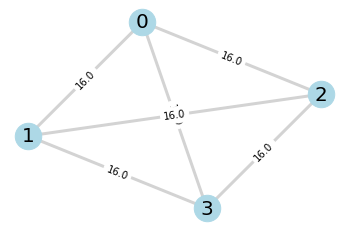

In [22]:
from utils.libqubo import show_bqm_graph
show_bqm_graph(bqm)

In [23]:
exactsolver = dimod.ExactSolver()
sampleset = exactsolver.sample(bqm)

# print the results with lowest energy
sampleset.to_pandas_dataframe().sort_values(by='energy')

,0,1,2,3,energy,num_occurrences
2,1,1,0,0,8.0,1
4,0,1,1,0,8.0,1
6,1,0,1,0,8.0,1
8,0,0,1,1,8.0,1
12,0,1,0,1,8.0,1
14,1,0,0,1,8.0,1
1,1,0,0,0,16.0,1
3,0,1,0,0,16.0,1
5,1,1,1,0,16.0,1
7,0,0,1,0,16.0,1


# Why I like to focus on D-Wave currently...

4 coloring problem for Canadian provinces
<img src="images/4color_1.jpg" width=500>

Scaling up using divide-and-concer strategies allows to solve much bigger instances.<br>
4 coloring problem for United States
<br>
<img src="images/4color_2.jpg" width=500>

For coloring problem for United States provinces
<img src="images/4color_4.jpg" width=500>

Currently D-Wave can work on up to 10k variables and the algorithms make huge progress to solve even larger problems very soon!!